In [ ]:
# launch XVFB if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

### Let's make a TRPO!

In this notebook we will write the code of the one Trust Region Policy Optimization.
As usually, it contains a few different parts which we are going to reproduce.



In [ ]:
import numpy as np
import theano
import theano.tensor as T

In [ ]:
import gym

env = gym.make("Acrobot-v1")
env.reset()

observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box(6,)
Action Space Discrete(3)


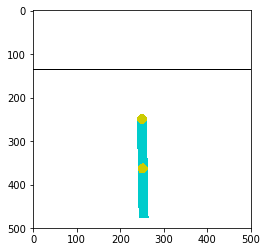

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(env.render('rgb_array'))

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method. 

This essentially means we're actually training a stochastic policy $ \pi_\theta(a|s) $. 

And yes, it's gonna be a neural network. So let's start by defining one.

In [ ]:
# input tensors
observations = T.matrix(name="obs")
actions = T.ivector(name="action")
cummulative_returns = T.vector(name="G = r + gamma*r' + gamma^2*r'' + ...")
old_probs = T.matrix(name="action probabilities from previous iteration")

all_inputs = [observations, actions, cummulative_returns, old_probs]

In [ ]:
# Create neural network.
from lasagne.layers import *

nn = InputLayer((None,)+observation_shape, input_var=observations)

<your network here >

policy = <layer that predicts action probabilities >

probs = get_output(policy)

weights = get_all_params(policy, trainable=True)

### Step 2: Actions and rollouts

In this section, we'll define functions that take actions $ a \sim \pi_\theta(a|s) $ and rollouts $ <s_0,a_0,s_1,a_1,s_2,a_2,...s_n,a_n> $.

In [ ]:
# compile function
get_policy = theano.function([observations], probs, allow_input_downcast=True)


def act(obs, sample=True):
    """
    Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
    :param: obs - single observation vector
    :param sample: if True, samples from \pi, otherwise takes most likely action
    :returns: action (single integer) and probabilities for all actions
    """

    policy = get_policy([obs])[0]

    if sample:
        action = int(np.random.choice(n_actions, p=policy))
    else:
        action = int(np.argmax(policy))

    return action, policy

In [ ]:
# demo
print("sampled:", [act(env.reset()) for _ in range(100)])
print("greedy:", [act(env.reset(), sample=False) for _ in range(100)])

Compute cummulative reward just like you did in vanilla REINFORCE

In [ ]:
import scipy.signal


def get_cummulative_returns(r, gamma=1):
    """
    Computes cummulative discounted rewards given immediate rewards
    G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
    Also known as R(s,a).
    """
    r = np.array(r)
    assert r.ndim >= 1
    return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]

In [ ]:
# simple demo on rewards [0,0,1,0,0,1]
get_cummulative_returns([0, 0, 1, 0, 0, 1], gamma=0.9)

**Rollout**

In [ ]:
def rollout(env, act, max_pathlength=2500, n_timesteps=50000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0
    while total_timesteps < n_timesteps:
        obervations, actions, rewards, action_probs = [], [], [], []
        obervation = env.reset()
        for _ in range(max_pathlength):
            action, policy = act(obervation)
            obervations.append(obervation)
            actions.append(action)
            action_probs.append(policy)
            obervation, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1
            if done or total_timesteps == n_timesteps:
                path = {"observations": np.array(obervations),
                        "policy": np.array(action_probs),
                        "actions": np.array(actions),
                        "rewards": np.array(rewards),
                        "cumulative_returns": get_cummulative_returns(rewards),
                        }
                paths.append(path)
                break
    return paths

In [ ]:
paths = rollout(env, act, max_pathlength=5, n_timesteps=100)
print(paths[-1])
assert (paths[0]['policy'].shape == (5, n_actions))
assert (paths[0]['cumulative_returns'].shape == (5,))
assert (paths[0]['rewards'].shape == (5,))
assert (paths[0]['observations'].shape == (5,)+observation_shape)
assert (paths[0]['actions'].shape == (5,))
print('It\'s ok')

### Step 3: loss functions

Now let's define the loss functions and constraints for actual TRPO training.

The surrogate reward should be
$$J_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}A_{\theta_{old}(s_i, a_i)}$$

For simplicity, let's use cummulative returns instead of advantage for now:
$$J'_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}G_{\theta_{old}(s_i, a_i)}$$

Or alternatively, minimize the surrogate loss:
$$ L_{surr} = - J'_{surr} $$

In [ ]:
# select probabilities of chosen actions
batch_size = actions.shape[0]

probs_for_actions = probs[T.arange(batch_size), actions]
old_probs_for_actions = old_probs[T.arange(batch_size), actions]

In [ ]:
# Compute surrogate loss: negative importance-sampled policy gradient

L_surr = <compute surrogate loss, aka _negative_ importance-sampled policy gradient >

In [ ]:
# compute and return surrogate policy gradient


def get_flat_gradient(loss, var_list):
    """gradient of loss wrt var_list flattened into a large vector"""
    grads = T.grad(loss, var_list)
    return T.concatenate([grad.ravel() for grad in grads])


get_surrogate_gradients = theano.function(all_inputs, get_flat_gradient(L_surr, weights),
                                          allow_input_downcast=True)

We can ascend these gradients as long as our $pi_\theta(a|s)$ satisfies the constraint
$$E_{s,\pi_{\Theta_{t}}}\Big[KL(\pi(\Theta_{t}, s) \:||\:\pi(\Theta_{t+1}, s))\Big]< \alpha$$


where

$$KL(p||q) = E _p log({p \over q})$$

In [ ]:
# Compute Kullback-Leibler divergence (see formula above)
# Note: you need to sum KL and entropy over all actions, not just the ones agent took
old_log_probs = T.log(old_probs + 1e-10)

kl = <cumpute kullback-leibler as per formula above >

# Compute policy entropy
entropy = <compute policy entropy. Don't forget the sign!>

compute_losses = theano.function(all_inputs, [L_surr, kl, entropy],
                                 allow_input_downcast=True)

**Linear search**

TRPO in its core involves ascending surrogate policy gradient constrained by KL divergence. 

In order to enforce this constraint, we're gonna use linesearch. You can find out more about it [here](https://en.wikipedia.org/wiki/Linear_search)

In [ ]:
def linesearch(f, x, fullstep, max_kl):
    """
    Linesearch finds the best parameters of neural networks in the direction of fullstep contrainted by KL divergence.
    :param: f - function that returns loss, kl and arbitrary third component.
    :param: x - old parameters of neural network.
    :param: fullstep - direction in which we make search.
    :param: max_kl - constraint of KL divergence.
    :returns:
    """
    max_backtracks = 10
    loss, _, _ = f(x)
    for stepfrac in .5 ** np.arange(max_backtracks):
        xnew = x + stepfrac * fullstep
        new_loss, kl, _ = f(xnew)
        actual_improve = new_loss - loss
        if kl <= max_kl and actual_improve < 0:
            x = xnew
            loss = new_loss
    return x

### Step 4: training
In this section we construct rest parts of our computational graph

In [ ]:
def slice_vector(vector, shapes):
    """
    Slices symbolic vector into several symbolic tensors of given shapes.
    Auxilary function used to un-flatten gradients, tangents etc.
    :param vector: 1-dimensional symbolic vector
    :param shapes: list or tuple of shapes (list, tuple or symbolic)
    :returns: list of symbolic tensors of given shapes
    """
    assert vector.ndim == 1, "vector must be 1-dimensional"
    start = 0
    tensors = []
    for shape in shapes:
        size = T.prod(shape)
        tensor = vector[start:(start + size)].reshape(shape)
        tensors.append(tensor)
        start += size
    return tensors

In [ ]:
conjugate_grad_intermediate_vector = T.vector(
    "intermediate grad in conjugate_gradient")

# slice flat_tangent into chunks for each weight
weight_shapes = [var.get_value().shape for var in weights]
tangents = slice_vector(conjugate_grad_intermediate_vector, weight_shapes)

# KL divergence where first arg is fixed
from theano.gradient import disconnected_grad as const
kl_firstfixed = (const(probs) * (const(T.log(probs)) -
                                 T.log(probs))).sum(axis=-1).mean()

# compute fisher information matrix (used for conjugate gradients and to estimate KL)
gradients = T.grad(kl_firstfixed, weights)
gradient_vector_product = [T.sum(g * t) for (g, t) in zip(gradients, tangents)]

fisher_vector_product = get_flat_gradient(
    sum(gradient_vector_product), weights)

compute_fisher_vector_product = theano.function(
    [observations, conjugate_grad_intermediate_vector], fisher_vector_product)

### TRPO helpers

Here we define a few helper functions used in the main TRPO loop

**Conjugate gradients**

Since TRPO includes contrainted optimization, we will need to solve Ax=b using conjugate gradients.

In general, CG is an algorithm that solves Ax=b where A is positive-defined. A is Hessian matrix so A is positive-defined. You can find out more about them [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

In [ ]:
from numpy.linalg import inv


def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    p = b.copy()
    r = b.copy()
    x = np.zeros_like(b)
    rdotr = r.dot(r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (p.dot(z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = r.dot(r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

In [ ]:
# This code validates conjugate gradients
A = np.random.rand(8, 8)
A = np.matmul(np.transpose(A), A)


def f_Ax(x):
    return np.matmul(A, x.reshape(-1, 1)).reshape(-1)


b = np.random.rand(8)

w = np.matmul(np.matmul(inv(np.matmul(np.transpose(A), A)),
                        np.transpose(A)), b.reshape((-1, 1))).reshape(-1)
print(w)
print(conjugate_gradient(f_Ax, b))

In [ ]:
# Compile a function that exports network weights as a vector
flat_weights = T.concatenate([var.ravel() for var in weights])
get_flat_weights = theano.function([], flat_weights)

# ... and another function that imports vector back into network weights
flat_weights_placeholder = T.vector("flattened weights")
assigns = slice_vector(flat_weights_placeholder, weight_shapes)

load_flat_weights = theano.function(
    [flat_weights_placeholder], updates=dict(zip(weights, assigns)))

##### Step 5: Main TRPO loop

Here we will train our network!

In [ ]:
import time
from itertools import count
from collections import OrderedDict

# this is hyperparameter of TRPO. It controls how big KL divergence may be between old and new policy every step.
max_kl = 0.01
cg_damping = 0.1  # This parameters regularize addition to
numeptotal = 0  # this is number of episodes that we played.

start_time = time.time()

for i in count(1):

    print("\n********** Iteration %i ************" % i)

    # Generating paths.
    print("Rollout")
    paths = rollout(env, act)
    print("Made rollout")

    # Updating policy.
    observations = np.concatenate([path["observations"] for path in paths])
    actions = np.concatenate([path["actions"] for path in paths])
    returns = np.concatenate([path["cumulative_returns"] for path in paths])
    old_probs = np.concatenate([path["policy"] for path in paths])
    inputs_batch = [observations, actions, returns, old_probs]

    old_weights = get_flat_weights()

    def fisher_vector_product(p):
        """gets intermediate grads (p) and computes fisher*vector """
        return compute_fisher_vector_product(observations, p) + cg_damping * p

    flat_grad = get_surrogate_gradients(*inputs_batch)

    stepdir = conjugate_gradient(fisher_vector_product, -flat_grad)
    shs = .5 * stepdir.dot(fisher_vector_product(stepdir))
    lm = np.sqrt(shs / max_kl)
    fullstep = stepdir / lm

    # Compute new weights with linesearch in the direction we found with CG

    def losses_f(flat_weights):
        load_flat_weights(flat_weights)
        return compute_losses(*inputs_batch)

    new_weights = linesearch(losses_f, old_weights, fullstep, max_kl)

    load_flat_weights(new_weights)

    # Report current progress
    L_surr, kl, entropy = compute_losses(*inputs_batch)
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = OrderedDict()
    numeptotal += len(episode_rewards)
    stats["Total number of episodes"] = numeptotal
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Entropy"] = entropy
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl
    stats["Surrogate loss"] = L_surr
    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))
    i += 1

# Homework option I: better sampling (10+pts)

In this section, you're invited to implement a better rollout strategy called _vine_.

![img](https://s17.postimg.cc/i90chxgvj/vine.png)

In most gym environments, you can actually backtrack by using states. You can find a wrapper that saves/loads states in [the mcts seminar](https://github.com/yandexdataschool/Practical_RL/blob/master/week10_planning/seminar_MCTS.ipynb).

You can read more about in the [TRPO article](https://arxiv.org/abs/1502.05477) in section 5.2.

The goal here is to implement such rollout policy (we recommend using tree data structure like in the seminar above).
Then you can assign cummulative rewards similar to `get_cummulative_rewards`, but for a tree.

__bonus task__ - parallelize samples using multiple cores

# Homework option II (10+pts)

Let's use TRPO to train evil robots! (pick any of two)
* [MuJoCo robots](https://gym.openai.com/envs#mujoco)
* [Box2d robot](https://gym.openai.com/envs/BipedalWalker-v2)

The catch here is that those environments have continuous action spaces. 

Luckily, TRPO is a policy gradient method, so it's gonna work for any parametric $\pi_\theta(a|s)$. We recommend starting with gaussian policy:

$$\pi_\theta(a|s) = N(\mu_\theta(s),\sigma^2_\theta(s)) = {1 \over \sqrt { 2 \pi {\sigma^2}_\theta(s) } } e^{ (a - 
\mu_\theta(s))^2 \over 2 {\sigma^2}_\theta(s) } $$

In the $\sqrt { 2 \pi {\sigma^2}_\theta(s) }$ clause, $\pi$ means ~3.1415926, not agent's policy.

This essentially means that you will need two output layers:
* $\mu_\theta(s)$, a dense layer with linear activation
* ${\sigma^2}_\theta(s)$, a dense layer with activation T.exp (to make it positive; like rho from bandits)

For multidimensional actions, you can use fully factorized gaussian (basically a vector of gaussians).

__bonus task__: compare performance of continuous action space method to action space discretization